Populating the interactive namespace from numpy and matplotlib
/Users/nab/Repos/SZ_filter


`%matplotlib` prevents importing * from pylab and numpy
/Users/nab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: The SafeConfigParser class has been renamed to ConfigParser in Python 3.2. This alias will be removed in future versions. Use ConfigParser directly instead.


/Users/nab/Desktop/Projects/SO_forecasts/lensgrid_grid-owl2_owl2.pkl
/Users/nab/Desktop/Projects/SO_forecasts/szgrid_CCATP-propv2_grid-owl2_v0.7.pkl
0.0549199581146
(222,)
20 64 222 222
0.0616009235382
1.04064893723
3.60012054443e-05


/Users/nab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: DeprecationWarning: You passed a bytestring as `filenames`. This will not work on Python 3. Use `cp.read_file()` or switch to using Unicode strings across the board.


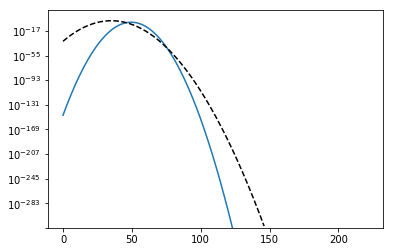

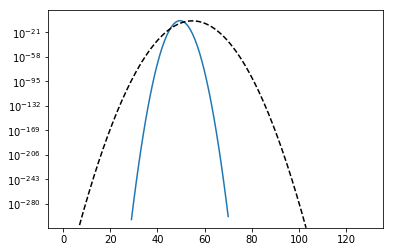

In [43]:
import numpy as np
from szar.counts import ClusterCosmology,Halo_MF
from szar.szproperties import SZ_Cluster_Model
from configparser import SafeConfigParser
from orphics.tools.io import dictFromSection,listFromConfig
import cPickle as pickle
import time
%pylab inline
import matplotlib.pyplot as plt

home = '/Users/nab/Repos/SZ_filter/'

!pwd

iniFile = home+'input/pipeline.ini'
expName = 'CCATP-propv2'
gridName = 'grid-owl2'
cal = 'owl2'

Config = SafeConfigParser()
Config.optionxform=str
Config.read(iniFile)

fparams = {}
for (key, val) in Config.items('params'):
    if ',' in val:
        param, step = val.split(',')
        fparams[key] = float(param)
    else:
        fparams[key] = float(val)

bigDataDir = Config.get('general','bigDataDirectory')
clttfile = Config.get('general','clttfile')
constDict = dictFromSection(Config,'constants')
clusterDict = dictFromSection(Config,'cluster_params')
beam = listFromConfig(Config,expName,'beams')
noise = listFromConfig(Config,expName,'noises')
freq = listFromConfig(Config,expName,'freqs')
lknee = listFromConfig(Config,expName,'lknee')[0]
alpha = listFromConfig(Config,expName,'alpha')[0]

calFile = bigDataDir+"lensgrid_grid-"+cal+"_"+cal+".pkl"

version = Config.get('general','version')

mexp_edges, z_edges, lndM = pickle.load(open(calFile,"rb"))

print calFile
print bigDataDir+"szgrid_"+expName+"_"+gridName+ "_v" + version+".pkl"
mgrid,zgrid,siggrid = pickle.load(open(bigDataDir+"szgrid_"+expName+"_"+gridName+ "_v" + version+".pkl",'rb'))

assert np.all(mgrid==mexp_edges)
assert np.all(z_edges==zgrid)

#print lndM

cc = ClusterCosmology(fparams,constDict,clTTFixFile=clttfile)
HMF = Halo_MF(cc,mgrid,zgrid)

qs = listFromConfig(Config,'general','qbins')
qspacing = Config.get('general','qbins_spacing')
if qspacing=="log":
    qbin_edges = np.logspace(np.log10(qs[0]),np.log10(qs[1]),int(qs[2])+1)
elif qspacing=="linear":
    qbin_edges = np.linspace(qs[0],qs[1],int(qs[2])+1)
else:
    raise ValueError
    
SZProp = SZ_Cluster_Model(cc,clusterDict,rms_noises = noise,fwhms=beam,freqs=freq,lknee=lknee,alpha=alpha)

Mwl = 10**HMF.Mexp
z_arr = HMF.zarr
M_arr =  np.outer(HMF.M,np.ones([len(z_arr)]))

#if HMF.sigN is None: HMF.updateSigN(SZProp)
#sigN = HMF.sigN
#np.savetxt(home+'/tests/sigN_arr_save.txt',sigN)

sigN = np.loadtxt(home+'/tests/sigN_arr_save.txt')

#SZProp = SZ_Cluster_Model(cc,clusterDict,rms_noises = noise,fwhms=beam,freqs=freq,lknee=lknee,alpha=alpha)

q_arr = (qbin_edges[1:]+qbin_edges[:-1])/2.

i = 5
kk = 2
jj = 10

start = time.time()
blah_orig = SZProp.P_of_qn(SZProp.lnY,M_arr[:,i],z_arr[i],sigN[:,i],q_arr)
print time.time() - start
blah_mwl = SZProp.Mwl_prob (Mwl[jj],M_arr[:,i],lndM[:,i])
print blah_mwl.shape 

print z_arr.size,q_arr.size,HMF.Mexp.size,Mwl.size

start = time.time()
blah = SZProp.P_of_qn_corr(SZProp.lnY,M_arr[:,i],z_arr[i],sigN[:,i],q_arr,Mwl[jj])#,lndM[:,i])
print time.time() - start

#start = time.time()
#test = np.zeros([len(HMF.Mexp),len(q_arr)])
#for kk in range(len(q_arr)):
#    test[:,kk] = SZProp.P_of_qn(SZProp.lnY,M_arr[:,i],z_arr[i],sigN[:,i],q_arr[kk])
#print "orig",time.time() - start

#start = time.time()
#test2 = SZProp.P_of_qn_arr(SZProp.lnY,M_arr[:,i],z_arr[i],sigN[:,i],q_arr)
#print "inner f loop",time.time() - start

#print test.shape
#print test2.shape

#print np.sum(test-test2)

start = time.time()
SZProp.Pfunc_qarr(sigN,HMF.M,z_arr,q_arr)
print time.time() - start
start = time.time()
#SZProp.Pfunc_qarr_corr(sigN,HMF.M,z_arr,q_arr,HMF.Mexp)#,lndM) # 4 minutes
print time.time() - start

#print blah_orig * blah_mwl
#print blah

#dN_dmqz_corr = HMF.N_of_mqz_SZ_corr(lndM,qbin_edges,SZProp)                                                                  
#dN_dmqz = HMF.N_of_mqz_SZ(lndM,qbin_edges,SZProp)

lnYa = np.outer(np.ones(len(M_arr[:,i])),SZProp.lnY)

#print SZProp.P_of_Y(lnYa,M_arr[:,i],z_arr[i]).shape
Check_YM = SZProp.P_of_Y_corr(lnYa,M_arr[:,i],z_arr[i],Mwl[jj])
numer = -1.*(np.outer(np.log(Mwl[jj]*SZProp.scaling['b_wl']/M_arr[:,i]),np.ones(len(SZProp.lnY))))**2
full = 1./(SZProp.scaling['Msig'] * np.sqrt(2*np.pi)) * np.exp(numer/(2.*SZProp.scaling['Msig']**2))
Check_YM_orig = SZProp.P_of_Y(lnYa,M_arr[:,i],z_arr[i]) * full

plt.figure()
plt.semilogy(Check_YM[:,50])
plt.plot(Check_YM_orig[:,50],'k--')

plt.figure()
plt.semilogy(Check_YM[50,:])
plt.plot(Check_YM_orig[50,:],'k--')

#print np.sum(Check_YM - Check_YM_orig)/np.sum(Check_YM_orig)


In [7]:
#print blah.shape, blah_orig.shape, blah_mwl.shape
#print blah, blah_orig* np.outer(blah_mwl,np.ones(len(q_arr)))
#print np.sum((blah - blah_orig*blah_mwl))#/np.sum(blah))
print np.sum((blah - (blah_orig * np.outer(blah_mwl,np.ones(len(q_arr))))))/np.sum(blah)

0.99999999998


In [ ]:
from szar.szproperties import gaussianMat2D
#from szar.szproperties import gaussianMat2D_forloop

NN = 222
LL = 130
rho = 0.0

randarr3 = np.random.random([2,NN,LL])
randarr = np.random.random([NN,LL])
randarr2 = np.random.random([NN,LL])
randl = np.arange(LL)*0.1
randm = np.random.random([NN])

ans = np.zeros([NN])
ans3 = np.zeros([NN,LL])
ans4 = np.zeros([NN,LL])

print randarr.shape, randarr2.shape,randl.shape,(np.diff(randl)).shape, (randarr*randarr2).shape
start = time.time()
for ii in range(NN):
    ans3[ii,:] = gaussianMat2D(randarr3[:,ii,:],1.,randm[ii],rho)
    #ans[ii] = np.trapz(randarr[ii,:]*randarr2[ii,:],randl,np.diff(randl))
#print ans
print time.time() - start

sig_y = randm
sig_x = randm*0.0 + 1.
rho_arr = randm*0.0 + rho

icov = np.array([[sig_y**2, -1.*sig_x*sig_y*rho_arr],[-1.*sig_x*sig_y*rho_arr, sig_x**2]]) / (sig_x**2* sig_y**2*(1 - rho_arr**2) )

print icov.shape
print randarr3.shape
int1 = np.einsum('ijk,jkl->ikl',icov,randarr3)
#int1 = np.dot(icov,randarr3)
print int1.shape
int2 = np.einsum('j...,j...->...',randarr3,int1)
print int2.shape
print ans3.shape

print ans3 - int2

#start = time.time()
#ans4 = gaussianMat2D_forloop(randarr3,1.,randm,rho)
#print "G inner",time.time() - start

#start = time.time()
#for ii in range(NN):
#    ans4[ii,:] = gaussianMat2D_old(randarr3[:,ii,:],1.,randm[ii],rho)
    #ans[ii] = np.trapz(randarr[ii,:]*randarr2[ii,:],randl,np.diff(randl))
#print ans
#print time.time() - start

start = time.time()
for ii in range(NN):
    #ans3[ii,:] = gaussianMat2D(randarr[:,ii,:],1.,randm[ii],rho)
    ans[ii] = np.trapz(randarr[ii,:]*randarr2[ii,:],randl,np.diff(randl))
#print ans
print time.time() - start

start = time.time()
ans2 = np.trapz(randarr*randarr2,randl,np.diff(randl),axis=1)
print time.time() - start
print np.sum(ans2-ans)
#print np.sum(ans3-ans4)
#ans2 = np.apply_along_axis(gaussianMat2D,1,randarr,1.,randm,rho)

(1000,)
(1000,)


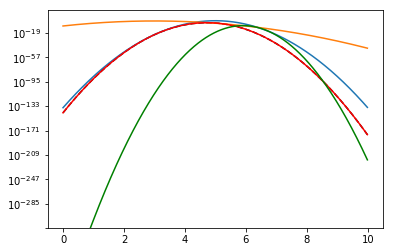

In [64]:
from szar.szproperties import gaussianMat2D

sig1 = 0.2
sig2 = 0.5

x = np.arange(1000)*.01
y = np.arange(1000)*.01
mux = 5.
muy = 3.

#numer1 = -1.0*(np.log(mux/x))**2
numer1 = -1.0*(mux-x)**2
ans1 = 1./(sig1* np.sqrt(2*np.pi)) * np.exp(numer1/(2.*sig1**2))
#numer2 = -1.0*(np.log(muy/y))**2
numer2 = -1.0*(muy-y)**2
ans2 = 1./(sig2* np.sqrt(2*np.pi)) * np.exp(numer2/(2.*sig2**2))
ans = ans1*ans2

#diff_x = np.log(mux/x)
#diff_y = np.log(muy/y)
diff_x = (mux - x)
diff_y = (muy - y)

diff_arr = np.array([diff_x,diff_y])

rho1 = 0.
rho2 = 0.9

corr1 = gaussianMat2D(diff_arr,sig1,sig2,rho1)
corr2 = gaussianMat2D(diff_arr,sig1,sig2,rho2)

print corr1.shape
print corr2.shape

plt.semilogy(x,ans,'k--')
plt.plot(x,ans1)
plt.plot(x,ans2)
plt.plot(x,corr1,'r')
plt.plot(x,corr2,'g')
